# LSTM with PayPal data

In [1]:
import pandas as pd
import numpy as np
import datetime
import random
from itertools import cycle
from keras.models import Sequential
from keras.layers import Dense, LSTM
from math import sqrt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot

## Load Data

In [2]:
df_d = pd.read_csv("days_data.csv", index_col=0)
df_m = pd.read_csv("minute_data.csv", index_col=0)
df_s = pd.read_csv("second_data.csv", index_col=0)

df_d.head()

values_d = df_d.values
values_m = df_m.values
values_s = df_s.values

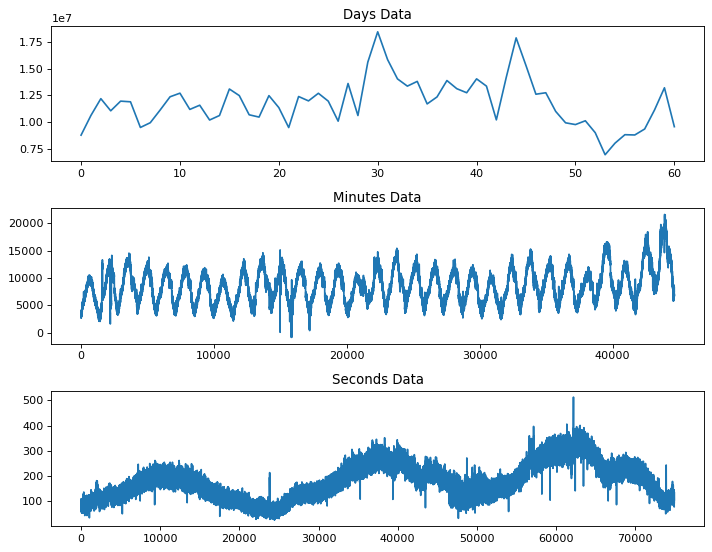

In [3]:
pyplot.figure(figsize=(9,7), dpi=80)

pyplot.subplot(3, 1, 1)
pyplot.plot(values_d[:, 0])
pyplot.title("Days Data")
pyplot.subplot(3, 1, 2)
pyplot.plot(values_m[:, 0])
pyplot.title("Minutes Data")
pyplot.subplot(3, 1, 3)
pyplot.plot(values_s[:, 0])
pyplot.title("Seconds Data")

pyplot.tight_layout()

pyplot.show()

## Function For Converting Series Data to Supervised Learning

In [4]:
# convert series to supervised learning
# developed in this blog post https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ..., t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
	# drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

## LSTM with Days Data

In [5]:
values = values_d
# integer encode day of the week
encoder = LabelEncoder()
values[:,1] = encoder.fit_transform(values[:,1])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)

reframed.drop(reframed.columns[3], axis=1, inplace=True)
reframed.head()

,var1(t-1),var2(t-1),var1(t)
1,0.159353,0.333333,0.320064
2,0.320064,0.500000,0.456297
3,0.456297,0.166667,0.357436
4,0.357436,0.833333,0.436070
5,0.436070,1.000000,0.430628


In [6]:
# split into train and test sets
values = reframed.values
n_train = 6
train = values[:n_train, :]
test = values[n_train:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(6, 1, 2) (6,) (54, 1, 2) (54,)


2021-10-19 14:20:01.576131: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-10-19 14:20:03.049329: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50
1/1 - 2s - loss: 0.3663 - val_loss: 0.4264
Epoch 2/50
1/1 - 0s - loss: 0.3603 - val_loss: 0.4208
Epoch 3/50
1/1 - 0s - loss: 0.3543 - val_loss: 0.4151
Epoch 4/50
1/1 - 0s - loss: 0.3483 - val_loss: 0.4095
Epoch 5/50
1/1 - 0s - loss: 0.3423 - val_loss: 0.4039
Epoch 6/50
1/1 - 0s - loss: 0.3363 - val_loss: 0.3983
Epoch 7/50
1/1 - 0s - loss: 0.3303 - val_loss: 0.3926
Epoch 8/50
1/1 - 0s - loss: 0.3242 - val_loss: 0.3870
Epoch 9/50
1/1 - 0s - loss: 0.3182 - val_loss: 0.3813
Epoch 10/50
1/1 - 0s - loss: 0.3121 - val_loss: 0.3756
Epoch 11/50
1/1 - 0s - loss: 0.3061 - val_loss: 0.3699
Epoch 12/50
1/1 - 0s - loss: 0.3000 - val_loss: 0.3642
Epoch 13/50
1/1 - 0s - loss: 0.2938 - val_loss: 0.3587
Epoch 14/50
1/1 - 0s - loss: 0.2877 - val_loss: 0.3531
Epoch 15/50
1/1 - 0s - loss: 0.2815 - val_loss: 0.3476
Epoch 16/50
1/1 - 0s - loss: 0.2754 - val_loss: 0.3420
Epoch 17/50
1/1 - 0s - loss: 0.2691 - val_loss: 0.3364
Epoch 18/50
1/1 - 0s - loss: 0.2629 - val_loss: 0.3307
Epoch 19/50
1/1 - 0

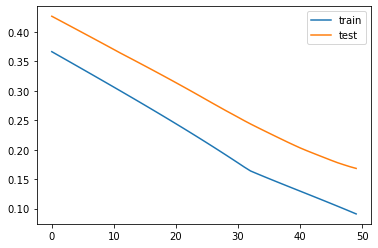

In [7]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [8]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

In [9]:
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)
normalized_rmse = rmse/(max(max(inv_yhat),max(inv_y))-min(min(inv_yhat),min(inv_y)))
print('Normalized RMSE: %.3f' % normalized_rmse)

Test RMSE: 2542395.997
Normalized RMSE: 0.223


## LSTM with Minutes Data

In [10]:
values = values_m
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)

#reframed.drop(reframed.columns[3], axis=1, inplace=True)
reframed.head()

,var1(t-1),var1(t)
1,0.200855,0.192219
2,0.192219,0.178597
3,0.178597,0.177217
4,0.177217,0.195735
5,0.195735,0.189770


In [11]:
# split into train and test sets
values = reframed.values
print(values.shape)
n_train = 4463
train = values[:n_train, :]
test = values[n_train:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(44639, 2)
(4463, 1, 1) (4463,) (40176, 1, 1) (40176,)


Epoch 1/50
62/62 - 2s - loss: 0.2656 - val_loss: 0.1387
Epoch 2/50
62/62 - 0s - loss: 0.0863 - val_loss: 0.0770
Epoch 3/50
62/62 - 0s - loss: 0.0808 - val_loss: 0.0704
Epoch 4/50
62/62 - 1s - loss: 0.0741 - val_loss: 0.0641
Epoch 5/50
62/62 - 1s - loss: 0.0678 - val_loss: 0.0581
Epoch 6/50
62/62 - 0s - loss: 0.0615 - val_loss: 0.0521
Epoch 7/50
62/62 - 0s - loss: 0.0551 - val_loss: 0.0462
Epoch 8/50
62/62 - 0s - loss: 0.0484 - val_loss: 0.0403
Epoch 9/50
62/62 - 0s - loss: 0.0413 - val_loss: 0.0344
Epoch 10/50
62/62 - 0s - loss: 0.0340 - val_loss: 0.0277
Epoch 11/50
62/62 - 0s - loss: 0.0267 - val_loss: 0.0214
Epoch 12/50
62/62 - 0s - loss: 0.0214 - val_loss: 0.0184
Epoch 13/50
62/62 - 0s - loss: 0.0188 - val_loss: 0.0178
Epoch 14/50
62/62 - 0s - loss: 0.0181 - val_loss: 0.0178
Epoch 15/50
62/62 - 1s - loss: 0.0179 - val_loss: 0.0179
Epoch 16/50
62/62 - 1s - loss: 0.0178 - val_loss: 0.0179
Epoch 17/50
62/62 - 1s - loss: 0.0178 - val_loss: 0.0179
Epoch 18/50
62/62 - 0s - loss: 0.0178 - 

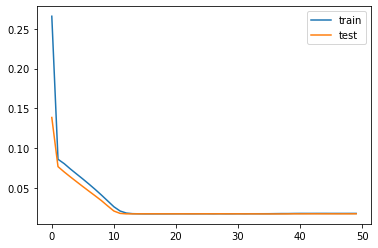

In [12]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [13]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

In [14]:
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)
normalized_rmse = rmse/(max(max(inv_yhat),max(inv_y))-min(min(inv_yhat),min(inv_y)))
print('Normalized RMSE: %.3f' % normalized_rmse)

Test RMSE: 513.171
Normalized RMSE: 0.022


## LSTM with Seconds Data

In [15]:
df_s.head()

,count
0,87
1,76
2,81
3,110
4,78


In [18]:
values = values_s
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)

#reframed.drop(reframed.columns[3], axis=1, inplace=True)
reframed.head()

,var1(t-1),var1(t)
1,0.125257,0.102669
2,0.102669,0.112936
3,0.112936,0.172485
4,0.172485,0.106776
5,0.106776,0.135524


In [23]:
# split into train and test sets
values = reframed.values
print(values.shape)
n_train = 14989
train = values[:n_train, :]
test = values[n_train:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(74949, 2)
(14989, 1, 1) (14989,) (59960, 1, 1) (59960,)


Epoch 1/50
209/209 - 13s - loss: 0.0389 - val_loss: 0.0998
Epoch 2/50
209/209 - 7s - loss: 0.0351 - val_loss: 0.0985
Epoch 3/50
209/209 - 4s - loss: 0.0350 - val_loss: 0.0976
Epoch 4/50
209/209 - 4s - loss: 0.0350 - val_loss: 0.0970
Epoch 5/50
209/209 - 5s - loss: 0.0350 - val_loss: 0.0966
Epoch 6/50
209/209 - 4s - loss: 0.0351 - val_loss: 0.0964
Epoch 7/50
209/209 - 4s - loss: 0.0351 - val_loss: 0.0961
Epoch 8/50
209/209 - 7s - loss: 0.0352 - val_loss: 0.0961
Epoch 9/50
209/209 - 4s - loss: 0.0353 - val_loss: 0.0961
Epoch 10/50
209/209 - 6s - loss: 0.0354 - val_loss: 0.0959
Epoch 11/50
209/209 - 5s - loss: 0.0355 - val_loss: 0.0959
Epoch 12/50
209/209 - 7s - loss: 0.0355 - val_loss: 0.0960
Epoch 13/50
209/209 - 4s - loss: 0.0356 - val_loss: 0.0958
Epoch 14/50
209/209 - 4s - loss: 0.0356 - val_loss: 0.0958
Epoch 15/50
209/209 - 4s - loss: 0.0358 - val_loss: 0.0957
Epoch 16/50
209/209 - 4s - loss: 0.0359 - val_loss: 0.0959
Epoch 17/50
209/209 - 5s - loss: 0.0358 - val_loss: 0.0959
Epoch

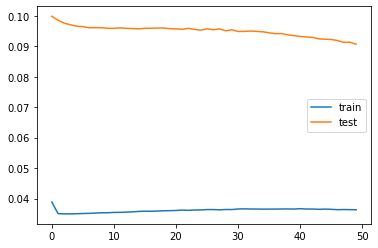

In [24]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [25]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

In [26]:
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)
normalized_rmse = rmse/(max(max(inv_yhat),max(inv_y))-min(min(inv_yhat),min(inv_y)))
print('Normalized RMSE: %.3f' % normalized_rmse)

Test RMSE: 53.418
Normalized RMSE: 0.110
